# COMP5318 - Machine Learning and Data Mining: Assignment 2
<div style="text-align: right"> Group 86 </div>
<div style="text-align: right"> tlin4302 | 470322974 | Jenny Tsai-chen Lin </div>
<div style="text-align: right"> jsun4242 | 500409987 | Jiawei Sun </div>
<div style="text-align: right"> jyan2937 | 480546614 | Jinxuan Yang </div>

## The notebook includes sections :
    Section 0. Hardware and software specifications 
    Section 1. Library and general functions 
    Section 2. Data pre-processing
    Section 3. Implement algorithms
        3.1 AdaBoost Classifier
        3.2 Convolutional Neural Network Classifier
        3.3 Support-Vector-Machine Classifier
    Section 4. Compare result between algorithms in train dataset 
    Section 5: Best perfroming algorithms in testing data  (we will submit this in seperate notebook as well)

## CODE RUNNING INSTRUCTIONS:
    Instruction:
    Simply change the switches in **0.Switches** blocks and run all.
    
    Dataset directory:
    Same directory as the jupyter notebook, in the format of :
    ---[current dir]
       |----[This file]
       |----[dataset]
          |----test
          |----train
          
          
    The default parameters will used the saved model to run simple tests,
    and load confusion matrices, accuracies, etc. from disk and plot them
    for display purpose.

### Hardware and software specifcations
hardware:
    1. CPU: Intel i7-8700K @ 3.70GHz
    2. RAM: 64G DDR4 3000MHz
    3. Graphics: NVidia GeForce GTX 1080Ti
    4. Chipset: Z370

### Software specifications

In [1]:
import os, platform
print('OS name:', os.name, ', system:', platform.system(), ', release:', platform.release())
import sys
print("Anaconda version:")
#!conda list anaconda
print("Python version: ", sys.version)
print("Python version info: ", sys.version_info)
import PIL
from PIL import Image
print("PIL version: ", PIL.__version__)
import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib version: ", matplotlib.__version__)
#import tensorflow as tf
#print("Keras version:", tf.keras.__version__)
import cv2
print("OpenCV version: ", cv2.__version__)
import numpy as np
print("nump version: ", np.__version__)

OS name: nt , system: Windows , release: 10
Anaconda version:
Python version:  3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Python version info:  sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)
PIL version:  7.2.0
Matplotlib version:  3.2.2
OpenCV version:  4.4.0
nump version:  1.18.5


## Section 0. Switches (Default settings is great for demo purpose)

#### Load saved model or run training?

In [2]:
load_saved_model = True

#### Run preprocessing benchmark or not?

In [3]:
run_preprocessing_benchmark = True

#### Run test code for 3 classifiers?

In [4]:
run_test_code_for_classifiers = True

#### number of threads when preprocessing images

In [5]:
g_thread_num = 6

#### Run hyper parameter tuning? (Slow if turned on!)

In [6]:
# Caution: Slow if turned on.
do_hyper_parameter_tuning = False

#### Run 10-fold cross validation? (Slow if turned on)

In [7]:
# Caution: Slow if turned on.
run_ten_fold = False

## Section 1. Library and general functions 

In [8]:
#  Go to anaconda prompt to install package imblearn
# anaconda: conda install -c glemaitre imbalanced-learn
#pip install kmeans-smote

from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2

import time

### global variables

In [9]:
# choose one of below two line depend file location******

g_dataset_dir = "./dataset/"   
#g_dataset_dir = "../dataset/" 


a_random_file = "./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg"  
#a_random_file = "../dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg" 

saved_model_path = "./saved_model/"
abc_model_file = saved_model_path + "abc_dump.pkl"
svc_model_file = saved_model_path + "svc_dump.pkl"
cnn_model_file = saved_model_path + "cnn_weights"

ten_fold_result_path = "./ten_fold_results/"


# define global variable 

g_train_dir = g_dataset_dir + "/train/"
g_test_dir = g_dataset_dir + "/test/"

g_image_size = 400

g_grid_row = 8
g_grid_col = 8

g_grid_num = g_grid_row * g_grid_col
g_grid_size = int(g_image_size / g_grid_row)


#Processing 1 - scale down 
g_down_sampled_size = 200
g_down_sampled_grid_size = int(g_grid_size / (g_image_size / g_down_sampled_size))

# global instance of mapping of char vs chess pieces
# reference: Forsyth–Edwards Notation, https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation
# 
# pawn = "P", knight = "N", bishop = "B", rook = "R", queen = "Q" and king = "K"
# White pieces are designated using upper-case letters ("PNBRQK") while black pieces use lowercase ("pnbrqk")
# we use 0 to note an empty grid.
# 13 items in total.

g_piece_mapping = {
    "P" : "pawn",
    "N" : "knight",
    "B" : "bishop",
    "R" : "rook",
    "Q" : "queen",
    "K" : "king",

    "p" : "pawn",
    "n" : "knight",
    "b" : "bishop",
    "r" : "rook",
    "q" : "queen",
    "k" : "king",

    "0" : "empty_grid"
}

g_num_labels = len(g_piece_mapping)

g_labels = ["P",
"N",
"B",
"R",
"Q",
"K",
"p",
"n",
"b",
"r",
"q",
"k",
"0"]


### Helper codes for label & board

In [10]:
#DataHelper.py

import os

import cv2
from skimage import io
import numpy as np

import glob
import h5py

# get clean name by a path, where in our case this gets the FEN conviniently
def GetCleanNameByPath(file_name):
    return os.path.splitext(os.path.basename(file_name))[0]

# get full paths to the files in a directory.
def GetFileNamesInDir(path_name, extension="*", num_return = 0):
    if num_return == 0:
        return glob.glob(path_name + "/*." + extension)
    else:
        return glob.glob(path_name + "/*." + extension)[:num_return]

# get name list
def GetCleanNamesInDir(path_name, extension = "*", num_return = 0):
    names = GetFileNamesInDir(path_name, extension)
    offset = len(extension) + 1
    clean_names = [os.path.basename(x)[:-offset] for x in names]
    if num_return == 0:
        return clean_names
    else:
        return clean_names[:num_return]

# read dataset
def ReadImages(file_names, path = "", format = cv2.IMREAD_COLOR):
    if path == "":
        return [cv2.imread(f, format) for f in file_names]
    else:
        return [cv2.imread(path + "/" + f, format) for f in file_names]

# read image by name
def ReadImage(file_name, gray = False):
    return io.imread(file_name, as_gray = gray)


# h5py functions
    
# read h5py file
# we assume the labels and 
def ReadH5pyFile(file_name, data_name):
    h5_buffer = h5py.File(file_name)
    return h5_buffer[data_name].copy()

# write h5py file
def WriteH5pyFile(file_name, mat, data_name = "dataset"):
    with h5py.File(file_name, 'w') as f:
        f.create_dataset(data_name, data = mat)


In [11]:
#BoardHelper.py

import re
import string
from collections import OrderedDict 

import numpy as np
import skimage.util
from skimage.util.shape import view_as_blocks

#from ChessGlobalDefs import *

#FEN TO LABELS OF SQUARES
def FENtoL(fen): 
    rules = {
        r"-": r"",
        r"1": r"0",
        r"2": r"00",
        r"3": r"000",
        r"4": r"0000",
        r"5": r"00000",
        r"6": r"000000",
        r"7": r"0000000",
        r"8": r"00000000",
    }

    for key in rules.keys():
        fen = re.sub(key, rules[key], fen)

    return list(fen)


# Label array to char list:
def LabelArrayToL(arr):
    rules = {
        0 : "P",
        1 : "N",
        2 : "B",
        3 : "R",
        4 : "Q",
        5 : "K",

        6 : "p",
        7 : "n",
        8 : "b",
        9 : "r",
       10 : "q",
       11 : "k",

       12 : "0"
    }

    flattened = arr.flatten(order = "C")

    L = []

    for x in flattened:
        L.append(rules[x])

    return L

# char list to FEN
def LtoFEN(L):

    FEN = ""
    
    for y in range(8):
        counter = 0
        for x in range(8):
            idx = x + y * 8
            char = L[idx]

            if char == "0":
                counter += 1
                if x == 7:
                    FEN += str(counter)
            else:
                if counter:
                    FEN += str(counter)
                    counter = 0

                FEN += char
        if y != 7:
            FEN += "-"
        
            
    return FEN



# FEN to one-hot encoding, in our case, it returns an 64 by 13 array, with each row as a one-hot to a grid.
def FENtoOneHot(fen):

    # this rule is in the same format as g_piece_mapping
    #rules = {
    #    "P" : np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "N" : np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "B" : np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "R" : np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "Q" : np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "K" : np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
    #                    
    #    "p" : np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
    #    "n" : np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
    #    "b" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
    #    "r" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
    #    "q" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
    #    "k" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
    #                    
    #    "0" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    #}
    rules = {
        "P" : 0,
        "N" : 1,
        "B" : 2,
        "R" : 3,
        "Q" : 4,
        "K" : 5,

        "p" : 6,
        "n" : 7,
        "b" : 8,
        "r" : 9,
        "q" : 10,
        "k" : 11,

        "0" : 12
    }

    L = FENtoL(fen)
    one_hot_array = np.zeros((g_grid_num, g_num_labels), dtype = np.int32) # 64 by 13
    for i, c in enumerate(L):
        one_hot_array[i, rules[c]] = 1

    return one_hot_array

# get 8*8 char matrix
def LtoCharMat(l):
    if type(l) == list:
        return np.array(l).reshape((8,8))
    if type(l) == str:
        return np.array([l]).reshape((8,8))

def GetBoardCell(board_image, row = 0, col = 0, size = 50):
    return np.array(board_image)[row*size:(row+1)*size,col*size:(col+1)*size]

# get grids of image
def ImageToGrids(image, grid_size_x, grid_size_y):
    return skimage.util.shape.view_as_blocks(image, block_shape = (grid_size_y, grid_size_x, 3)).squeeze(axis = 2)

# get grids of image
def ImageToGrids_grey(image, grid_size_x, grid_size_y):
    return skimage.util.shape.view_as_blocks(image, block_shape = (grid_size_y, grid_size_x, 1)).squeeze(axis = 2)


## Section 2. Data pre-processing

### Pre-processing - generic

In [12]:
# split into 64 small square from 1 board
# image resized to 400x 400 to 200x 200. 64 square at 25x 25 each

def PreprocessImage(image):
    image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
    # 1st and 2nd dim is 8
    grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)

    return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)

# split into 64 small square from 1 board -
# output of x: number of image x 64 x 25 x 25 x 3 , y: number of image x 64 x 13
def func_generator(train_file_names):
    x = []
    y = []
    for image_file_name in train_file_names:
        img = ReadImage(image_file_name)
        x.append(PreprocessImage(img))
        y.append(np.array(FENtoOneHot(GetCleanNameByPath(image_file_name))))
        
    return np.array(x), np.array(y)

x type : <class 'numpy.ndarray'>
x shape: (1, 64, 25, 25, 3)
y type : <class 'numpy.ndarray'>
y shape: (1, 64, 13)



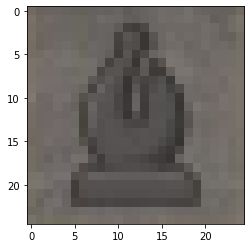

In [13]:
# Example output for a file - generic
num_train = 1
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)

x, y = func_generator(train_file_names)

print("x type :", type(x))
print("x shape:", x.shape)
print("y type :", type(y))
print("y shape:", y.shape)
print()
plt.imshow(x[0][1])

### Pre-processing - canny

In [14]:
# Processing image with canny
import cv2

def PreprocessImage_canny(image):
    image = cv2.Canny(image,100,200)
    image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
    # 1st and 2nd dim is 8
    image = image[..., np.newaxis]
    grids = ImageToGrids_grey(image, g_down_sampled_grid_size, g_down_sampled_grid_size)
    return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size)

# atomic func:
def func_canny(file_name):
    img = ReadImage(file_name)
    x = PreprocessImage_canny(img)
    y = np.array(FENtoL(GetCleanNameByPath(file_name)))
    return x, y
    
# split into 64 small square from 1 - output of x: number of image x64 x 25 x25 , y:number of image x 64
def func_generator_canny(image_file_names):
    xs = []
    ys = []
    for image_file_name in image_file_names:
        x, y = func_canny(image_file_name)
        xs.append(x)
        ys.append(y)
        
    return xs, ys


x type    : <class 'list'>
x[0] type : <class 'numpy.ndarray'>
x[0] shape: (64, 25, 25)
y type    : <class 'list'>
y[0] type : <class 'numpy.ndarray'>
y[0] shape: (64,)


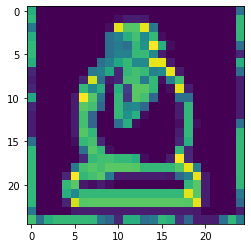

In [15]:
# Example output for a file - canny

num_train = 1
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)

x, y = func_generator_canny(train_file_names)

print("x type    :", type(x))
print("x[0] type :", type(x[0]))
print("x[0] shape:", x[0].shape)
print("y type    :", type(y))
print("y[0] type :", type(y[0]))
print("y[0] shape:", y[0].shape)

plt.imshow(x[0][1])

### Pre-processing - SIFT 

In [16]:
# Processing image with sift
import cv2

def ExtractSIFTForGrid(board_image, row, col, center_x = 25, center_y = 25, radius = 45):
    kps = [cv2.KeyPoint(x = center_x + 50 * col, y = center_y + 50 * row, _size = 45)]
    
    # USE THE CORRECT VERSION OF CV2
    if cv2.__version__ == "4.4.0":
        keypoints, descriptors = cv2.SIFT_create(edgeThreshold = 0).compute(image = board_image, keypoints = kps)
    else:
        keypoints, descriptors = cv2.xfeatures2d.SIFT_create(edgeThreshold = 0).compute(image = board_image, keypoints = kps)

    return keypoints[0], descriptors[0, :]



def PreprocessImage_sift(image):
    # 1st and 2nd dim is 8
    desc=[]
    for i in range(8):
        for j in range(8):  
            kp, d= ExtractSIFTForGrid(image,i,j)
            desc.append(np.array(d))
    return desc

# atomic func:
def func_sift(file_name):
    img = ReadImage(file_name)
    x = PreprocessImage_sift(img)
    y = np.array(FENtoL(GetCleanNameByPath(file_name)))
    return x, y
    
    
# split into 64 small square from 1  - output of x: number of image x64 x128 , y:number of image x 64
def func_generator_sift(image_file_names):
    xs = []
    ys = []
    for image_file_name in image_file_names:
        x, y = func_sift(image_file_name)
        xs.append(np.array(x))
        ys.append(np.array(y))
        
    return xs, ys


x type    : <class 'list'>
x[0] type : <class 'numpy.ndarray'>
x[0] shape: (64, 128)
y type    : <class 'list'>
y[0] type : <class 'numpy.ndarray'>
y[0] shape: (64,)


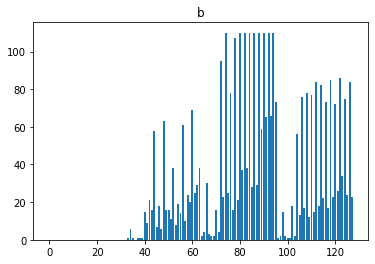

In [17]:
# Example output for a file - SIFT

num_train = 1
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)

x, y = func_generator_sift(train_file_names)

print("x type    :", type(x))
print("x[0] type :", type(x[0]))
print("x[0] shape:", x[0].shape)
print("y type    :", type(y))
print("y[0] type :", type(y[0]))
print("y[0] shape:", y[0].shape)

plt.bar(x = range(128), height = x[0][1])
plt.title(y[0][1])
plt.xticks(x = range(128))
plt.show()

### Example of image input, canny, SIFT

(400, 400, 3)
(400, 400)
(400, 400)
file name: ./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg


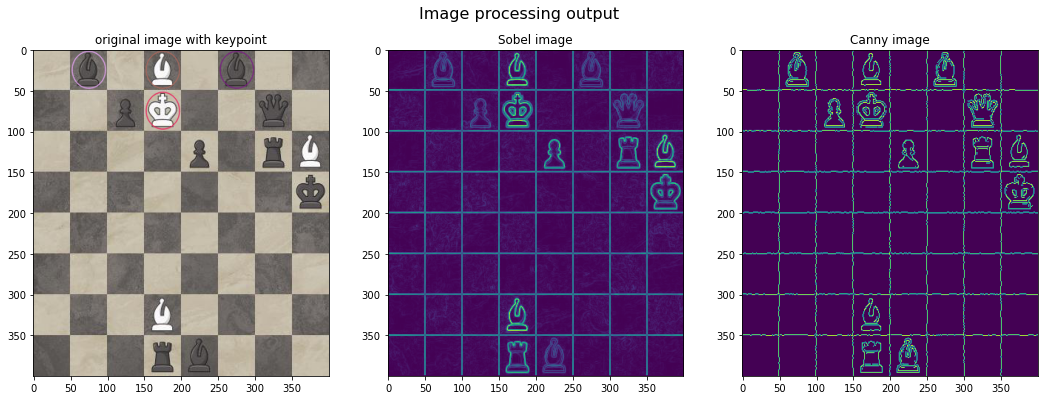

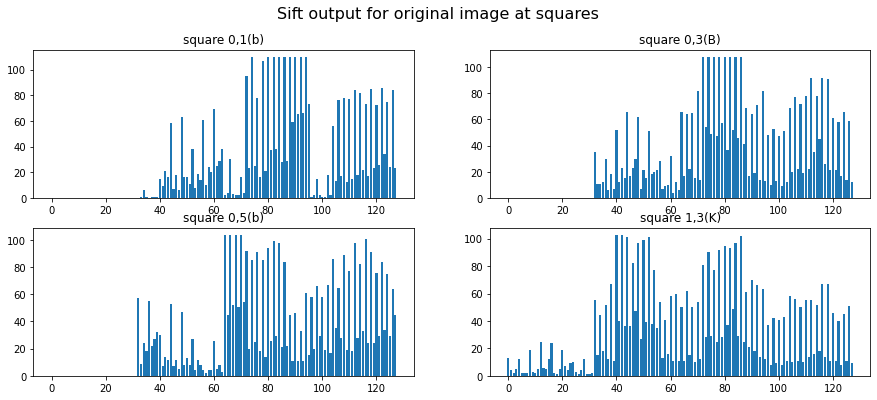

In [18]:
import cv2
from skimage.filters import sobel

#print("Sift: decriptor size:", cv2.SIFT_create().descriptorSize())
img = ReadImage(a_random_file)
img1 = cv2.Canny(img,100,200)
img2= sobel(img[:,:,0])
print(img.shape)
print(img1.shape)
print(img2.shape)

kp, desc = ExtractSIFTForGrid(img, 0, 1)
kp2, desc2 = ExtractSIFTForGrid(img, 0, 3)
kp3, desc3 = ExtractSIFTForGrid(img, 0, 5)
kp4, desc4 = ExtractSIFTForGrid(img, 1, 3)
img_kp = cv2.drawKeypoints(img, [kp, kp2,kp3,kp4], img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp1 = cv2.drawKeypoints(img1, [kp, kp2,kp3,kp4], img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


print('file name:',a_random_file)


plt.figure(figsize=(18,6))
plt.suptitle('Image processing output', fontsize=16)
plt.subplot(1, 3, 1)
plt.imshow(img_kp, aspect='auto')
plt.title('original image with keypoint')

plt.subplot(1, 3, 2)
plt.imshow(img2, aspect='auto')
plt.title('Sobel image')

plt.subplot(1, 3, 3)
plt.imshow(img1, aspect='auto')
plt.title('Canny image')
plt.show()

plt.figure(figsize=(15,6))
plt.suptitle('Sift output for original image at squares', fontsize=16)
#plt.tight_layout()
plt.subplot(2, 2, 1)
plt.title('square 0,1(b)')
plt.bar(x = range(128), height = desc)
plt.xticks(x = range(128))

plt.subplot(2,2, 2)
plt.title('square 0,3(B)')
plt.bar(x = range(128), height = desc2)
plt.xticks(x = range(128))

plt.subplot(2,2,3)
plt.title('square 0,5(b)')
plt.bar(x = range(128), height = desc3)
plt.xticks(x = range(128))


plt.subplot(2,2,4)
plt.title('square 1,3(K)')
plt.bar(x = range(128), height = desc4)
plt.xticks(x = range(128))
plt.show()



###  Read image - generic, canny, sift - run time

In [19]:
if run_preprocessing_benchmark:
    start_time = time.time()
    num_train = 100
    train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)

    X_org,Y_org = func_generator(train_file_names)
    print('runnning time for generic 100 images')
    print('--- {} seconds ---'.format(time.time() - start_time))

    X_sift,Y_sift = func_generator_sift(train_file_names)
    print('runnning time for sift 100 images')
    print('--- {} seconds ---'.format(time.time() - start_time))

    start_time = time.time()
    X_canny,Y_canny = func_generator_canny(train_file_names)
    print('runnning time for canny 100 images')
    print('--- {} seconds ---'.format(time.time() - start_time))

runnning time for generic 100 images
--- 1.9594979286193848 seconds ---
runnning time for sift 100 images
--- 28.49899911880493 seconds ---
runnning time for canny 100 images
--- 0.7249987125396729 seconds ---


### Subset train data - high quality (image level)

In [20]:
#https://www.researchgate.net/post/How_to_use_clustering_to_reduce_data_set_samples

#subset data of high quality image (at image level)

#Output is 
def file_names_highquality(image_file_names, min_piece =15):
    names = np.array(image_file_names)
    idx_sub = []
    for idx in range(len(image_file_names)):
        y = FENtoL(GetCleanNameByPath(image_file_names[idx]))
        piece_count = 64 - y.count('0')
        if piece_count >= min_piece:
            idx_sub.append(idx)    
    
    return np.array(image_file_names)[idx_sub]

In [21]:
# test  
if run_preprocessing_benchmark:
    file_name_reduced = file_names_highquality(train_file_names, min_piece =15)
    print('reduced file number from',len(train_file_names),'to',len(file_name_reduced))

reduced file number from 100 to 21


### Undersempling -square (grid level)

In [22]:
# install the package if needed.
if run_preprocessing_benchmark:
    !pip install imblearn

Looking in indexes: https://pypi.douban.com/simple


In [23]:
#subset data (in square level)
#ref: #https://www.researchgate.net/post/How_to_use_clustering_to_reduce_data_set_samples
# implement using https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.ClusterCentroids.html

if run_preprocessing_benchmark:
    from imblearn.under_sampling import ClusterCentroids

    # output x: number of grid x 125, y: number of grid
    def undersampling_ClusterCentroids_canny(X,Y):
        trans = ClusterCentroids(random_state=0)
        length=len(np.array(Y))
        X= np.array(X).reshape(length*64,25*25)
        Y = np.array(Y).reshape(length*64)
        X_resampled, y_resampled = trans.fit_sample(X, Y)

        return X_resampled, y_resampled

    # output x: number of grid x 128, y: number of grid
    def undersampling_ClusterCentroids_sift(X,Y):
        trans = ClusterCentroids(random_state=0)
        length=len(np.array(Y))
        X= np.array(X).reshape(length*64,128)
        Y = np.array(Y).reshape(length*64)
        X_resampled, y_resampled = trans.fit_sample(X, Y)
        return X_resampled, y_resampled

In [24]:
if run_preprocessing_benchmark:
    # test canny -resampled

    start_time = time.time()
    X_resampled_canny, Y_resampled_canny = undersampling_ClusterCentroids_canny(X_canny,Y_canny)
    print('--- {} seconds ---'.format(time.time() - start_time))
    print('reduce grid number from',len(np.array(Y_canny))*64,'to',len(np.array(Y_resampled_canny)))

    # test sift -resampled

    start_time = time.time()
    X_resampled_sift, Y_resampled_sift = undersampling_ClusterCentroids_sift(X_sift,Y_sift)
    print('--- {} seconds ---'.format(time.time() - start_time))
    print('reduce grid number from',len(np.array(Y_sift))*64,'to',len(np.array(Y_resampled_sift)))

--- 5.019449710845947 seconds ---
reduce grid number from 6400 to 455
--- 4.656001806259155 seconds ---
reduce grid number from 6400 to 455


###  Read Image - parallel version

In [25]:
from joblib import Parallel, delayed

# note: functions are first-class objects in Python. we pass it directly as parameter.
def Preprocess_parallel(func, file_names, job_count = 6):
    result = Parallel(n_jobs=job_count)(delayed(func)(file_name) for file_name in file_names)
    return zip(*result)

In [26]:
if run_preprocessing_benchmark:
    start_time = time.time()
    num_train = 100
    train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)

    xs, ys = Preprocess_parallel(func_canny, train_file_names)
    print('--- {} seconds ---'.format(time.time() - start_time))

--- 1.9814999103546143 seconds ---


### Read file names

In [27]:
if do_hyper_parameter_tuning:
    # Using FEN to identify grid with chess

    num_train = 500 # small bath train
    num_test= 500   # small bath train

    # Reading lables
    train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)
    test_file_names = GetFileNamesInDir(g_test_dir, extension = "jpeg",num_return = num_test)

## Section 3. Implement algorithms

### Section 3.0 AdaBoostClassifier (ABC) Prototype

#### Import data - SIFT output ( n x  128)  

In [28]:
if do_hyper_parameter_tuning:
    # import data - train

    start_time = time.time()
    #xs_train, ys_train = Preprocess_parallel(train_file_names)  
    xs_train_sift, ys_train_sift = Preprocess_parallel(func_sift, train_file_names)  #[JL - I broke Preprocess_parallel. use this instead ]
    print('xs_train_sift, ys_train_sift generated:',len(xs_train_sift))
    print(np.array(xs_train_sift).shape, np.array(ys_train_sift).shape)
    print('--- {} seconds ---'.format(time.time() - start_time))

    # import data - test

    start_time = time.time()
    #xs_train, ys_train = Preprocess_parallel(train_file_names)  
    xs_test_sift, ys_test_sift = Preprocess_parallel(func_sift, test_file_names)  #[JL - I broke Preprocess_parallel. use this instead ]
    print('xs_test_sift, ys_test_sift generated:',len(xs_test_sift))
    print(np.array(xs_test_sift).shape, np.array(ys_test_sift).shape)
    print('--- {} seconds ---'.format(time.time() - start_time))

#### intital prediction accuracy in sift data

In [29]:
if do_hyper_parameter_tuning:
    xs_train_sift2= np.array(xs_train_sift).reshape(500*64,128)
    ys_train_sift2 = np.array(ys_train_sift).reshape(500*64)
    print('shape of train data:',np.array(xs_train_sift2).shape, np.array(ys_train_sift2).shape)

    # ABC classifier

    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    start_time = time.time()

    ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, random_state=42)
    ada.fit(xs_train_sift2,ys_train_sift2)
    y_pred= ada.predict(xs_train_sift2)

    #Evaluate its performance on the training and test set
    print("AdaBoost- accuracy on validation set:", accuracy_score(ys_train_sift2 ,y_pred))
    print('--- {} seconds ---'.format(time.time() - start_time))

#### Import data - canny output ( n x  25 x 25 ) 

In [30]:
if do_hyper_parameter_tuning:
    # import data - train 500

    start_time = time.time()
    #xs_train, ys_train = Preprocess_parallel(train_file_names)  
    xs_train_canny, ys_train_canny = func_generator_canny(train_file_names)  #[JL - I broke Preprocess_parallel. use this instead ]
    print('xs_train_canny, ys_train_canny generated:',len(xs_train_canny))
    print(np.array(xs_train_canny).shape, np.array(ys_train_canny).shape)
    print('--- {} seconds ---'.format(time.time() - start_time))

    # import data - test 500

    start_time = time.time()
    #xs_train, ys_train = Preprocess_parallel(train_file_names)  
    xs_test_canny, ys_test_canny = func_generator_canny(test_file_names)  #[JL - I broke Preprocess_parallel. use this instead ]
    print('xs_test_canny, ys_test_canny generated:',len(xs_test_canny))
    print(np.array(xs_test_canny).shape, np.array(ys_test_canny).shape)
    print('--- {} seconds ---'.format(time.time() - start_time))

#### intital prediction accuracy in canny data

In [31]:
if do_hyper_parameter_tuning:
    xs_train_canny2= np.array(xs_train_canny).reshape(500*64,25*25)
    ys_train_canny2 = np.array(ys_train_canny).reshape(500*64)
    print('shape of train data:',np.array(xs_train_canny2).shape, np.array(ys_train_canny2).shape)

    # ABC classifier

    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    start_time = time.time()

    ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, random_state=42)
    ada.fit(xs_train_canny2,ys_train_canny2)
    y_pred= ada.predict(xs_train_canny2)

    #Evaluate its performance on the training and test set
    print("AdaBoost- accuracy on validation set:", accuracy_score(ys_train_canny2 ,y_pred))
    print('--- {} seconds ---'.format(time.time() - start_time))

### Proceed with canny data

#### Split train to train and validation

In [32]:
if do_hyper_parameter_tuning:
    #split 500 training data
    start_time = time.time()

    test_size=0.33

    from sklearn.model_selection import train_test_split
    X_train, X_val, Y_train, Y_val = train_test_split(
        xs_train_canny,ys_train_canny, test_size=0.33, random_state=0)
    print(np.array(X_train).shape, np.array(X_val).shape, np.array(Y_train).shape, np.array(Y_val).shape)
    print('--- {} seconds ---'.format(time.time() - start_time))

#### Undersampling traing set 

In [33]:
if do_hyper_parameter_tuning:
    # test sift -resampled

    start_time = time.time()

    X_resampled, Y_resampled = undersampling_ClusterCentroids_canny(X_train,Y_train)
    print('--- {} seconds ---'.format(time.time() - start_time))
    print('reduce grid number from',len(np.array(Y_train))*64,'to',len(np.array(Y_resampled)))
    print('shape of resampled data:',np.array(X_resampled).shape, np.array(Y_resampled).shape)

In [34]:
if do_hyper_parameter_tuning:
    # reshpe train daa, validation data, and testing data as resampled

    X_train= np.array(X_train).reshape(335*64,25*25)
    Y_train = np.array(Y_train).reshape(335*64)
    print('shape of train data:',np.array(X_train).shape, np.array(Y_train).shape)

    X_val= np.array(X_val).reshape(165*64,25*25)
    Y_val = np.array(Y_val).reshape(165*64)
    print('shape of validation data:',np.array(X_val).shape, np.array(Y_val).shape)

    xs_test_canny= np.array(xs_test_canny).reshape(num_test*64,25*25)
    ys_test_canny = np.array(ys_test_canny).reshape(num_test*64)
    print('shape of test data:',np.array(xs_test_canny).shape, np.array(ys_test_canny).shape)


#### Base classifier- Tree (with canny & canny resampling)

In [35]:
if do_hyper_parameter_tuning:
    # Tree classifier - Canny data 
    from sklearn.tree import DecisionTreeClassifier

    start_time = time.time()
    #Apply pre-pruning by limiting the depth of the tree - max_depth=2
    tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
    tree.fit(X_train, Y_train)
    #Evaluate its performance on the training and test set
    print("Accuracy on training set: {:.3f}".format(tree.score(X_train, Y_train)))
    print("Accuracy on validation set: {:.3f}".format(tree.score(X_val, Y_val)))
    print("Accuracy on testing set: {:.3f}".format(tree.score(xs_test_canny, ys_test_canny)))
    print('--- {} seconds ---'.format(time.time() - start_time))

In [36]:
if do_hyper_parameter_tuning:
    # Tree classifier - Canny & resampling data
    from sklearn.tree import DecisionTreeClassifier

    start_time = time.time()
    #Apply pre-pruning by limiting the depth of the tree 
    tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
    tree.fit(X_resampled, Y_resampled)
    #Evaluate its performance on the training and test set
    print("Accuracy on training set: {:.3f}".format(tree.score(X_train, Y_train)))
    print("Accuracy on validation set: {:.3f}".format(tree.score(X_val, Y_val)))
    print("Accuracy on testing set: {:.3f}".format(tree.score(xs_test_canny, ys_test_canny)))
    print('--- {} seconds ---'.format(time.time() - start_time))

#### AdaBoostClassifier- Tree (with canny & canny resampling)

In [37]:
if do_hyper_parameter_tuning:
    # ABC classifier- Canny data

    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    start_time = time.time()

    ada = AdaBoostClassifier(n_estimators=50,
                             base_estimator = DecisionTreeClassifier(criterion='gini', max_depth=5),
                             learning_rate=0.5,
                             random_state=42)
    ada.fit(X_train, Y_train)
    y_pred_val = ada.predict(X_val)
    y_pred_test = ada.predict(xs_test_canny)

    #Evaluate its performance on the training and test set
    print("AdaBoost- accuracy on validation set:", accuracy_score(Y_val, y_pred_val))
    print("AdaBoost- accuracy on testing set:", accuracy_score(ys_test_canny, y_pred_test))
    print('--- {} seconds ---'.format(time.time() - start_time))

In [38]:
if do_hyper_parameter_tuning:
    # ABC classifier- Canny & resampling  data

    start_time = time.time()

    ada = AdaBoostClassifier(n_estimators=50,
                             base_estimator = DecisionTreeClassifier(criterion='gini', max_depth=5),
                             learning_rate=0.5,
                             random_state=42)
    ada.fit(X_resampled, Y_resampled)
    y_pred_val = ada.predict(X_val)
    y_pred_test = ada.predict(xs_test_canny)

    #Evaluate its performance on the training and test set
    print("AdaBoost- accuracy on validation set:", accuracy_score(Y_val, y_pred_val))
    print("AdaBoost- accuracy on testing set:", accuracy_score(ys_test_canny, y_pred_test))
    print('--- {} seconds ---'.format(time.time() - start_time))

####  Hyper parameter tunning

In [39]:
###https://machinelearningmastery.com/adaboost-ensemble-in-python/

if do_hyper_parameter_tuning:
    
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.model_selection import GridSearchCV

    # AdaBoost
    param_grid = [{'n_estimators': np.arange(10,50,5),
                  'learning_rate': [0.01, 0.05, 0.1, 1,5,10]
                 }]

    start_time = time.time()
    abc = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid)
    abc.fit(X_resampled, Y_resampled)  

    print('--- {} seconds ---'.format(time.time() - start_time))

    # SVC
    param_grid = [{'n_estimators': np.arange(10,50,5),
                  'learning_rate': [0.01, 0.05, 0.1, 1,5,10],
                   "kernel" : ["linear", "poly", "rbf", "sigmoid"],
                   "C" : [0.01, 1, 10, 100]
                 }]

    start_time = time.time()
    svc = GridSearchCV(svm.SVC(random_state=42), param_grid)
    abc.fit(X_resampled, Y_resampled)  

    print('--- {} seconds ---'.format(time.time() - start_time))
    
    
    
else:
    print("Hyper parameter tuning skipped.")

Hyper parameter tuning skipped.


#### GridSearchCV Result

In [40]:

if do_hyper_parameter_tuning:

    # Print grid search results
    from sklearn.metrics import classification_report

    means = abc.cv_results_['mean_test_score']
    stds = abc.cv_results_['std_test_score']
    params = abc.cv_results_['params']

    print('Grid search mean and stdev:\n')

    for mean, std, p in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, p))

    # Print best params
    print('\nBest parameters:', abc.best_params_)
    print("Detailed classification report:")
    print()
    print(classification_report(Y_val, abc.predict(X_val)))
    print()
else:
    print("Adaboost: Hyper parameter report skipped.")

Adaboost: Hyper parameter report skipped.


## Section 3.1 SVM Classifier (SVC)

#### Base class for all classifiers

In [41]:
import abc

# interface of the classifiers
class IClassifier:

    # this method should accept a list of file names of the training data
    @abc.abstractmethod
    def Train(self, train_file_names):
        raise NotImplementedError()

    # this should accept a 400 * 400 * 3 numpy array as query data, and returns the fen notation of the board.
    @abc.abstractmethod
    def Predict(self, query_data):
        raise NotImplementedError()
        
    # this should accept a list of file names, and returns the predicted labels as 1d numpy array.
    @abc.abstractmethod
    def Predict(self, query_data):
        raise NotImplementedError()   

#### Class definition for SVC

In [42]:
from sklearn import svm
import numpy as np

# image io and plotting
from skimage import io, transform
import skimage.util
from skimage.util.shape import view_as_blocks
from matplotlib import pyplot as plt

# parallel processing
from joblib import Parallel, delayed
# model save and load
import pickle
import os
# profiling
import time

# joblib needs the kernel to be a top-level function, so we defined it here.
def PreprocessKernel(name):
    img = ReadImage(name, gray = True)
    grids = SVCClassifier.SVCPreprocess(img)
    labels = np.array(FENtoOneHot(GetCleanNameByPath(name))).argmax(axis=1)
    return grids, labels

# SVM Classifier
class SVCClassifier(IClassifier):

    def __init__(self):
        self.__svc__ = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                          decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
                          max_iter=-1, probability=False, random_state=None, shrinking=True,
                          tol=0.001, verbose=False)

    # this method should accept a list of file names of the training data
    def Train(self, train_file_names):
        print("svc: reading image.")
        start_time = time.time()
        xs, ys = SVCClassifier.PreprocessParallelWrapperFunc(train_file_names)
        print("svc: finished reading image, {} sec.".format(time.time() - start_time))
        # train
        print("svc: start training.")
        start_time = time.time()
        self.__svc__.fit(xs, ys)
        print("svc: finished. {} sec.".format(time.time() - start_time))

    # this should accept a 400 * 400 * 3 numpy array as query data, and returns the fen notation of the board.
    def Predict(self, query_data):
        grids = SVCClassifier.SVCPreprocess(query_data)
        y_pred = self.__svc__.predict(grids)
        
        return LabelArrayToL(y_pred)

    # predict by file name:
    def PredictMultiple(self, file_names):
        preds = []
        truth = []
        for f in file_names:
            img = ReadImage(f, gray = True)
            y_pred = self.Predict(img)
            y_true = FENtoL(GetCleanNameByPath(f))
            preds.append(y_pred)
            truth.append(y_true)
        
        all_pred = np.vstack(preds)
        all_truth = np.vstack(truth)
        return all_pred, all_truth
        
    # parallel pre-process wrapper:
    @staticmethod
    def PreprocessParallelWrapperFunc(file_names, num_thread = g_thread_num):
        result = Parallel(n_jobs = num_thread)(delayed(PreprocessKernel)(file_name) for file_name in file_names)
        xs, ys = zip(*result)
        xs = np.concatenate(xs, axis=0)
        ys = np.concatenate(ys)
        return xs, ys

    @staticmethod
    def SVCPreprocess(img):
        img = transform.resize(img, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        grids = skimage.util.shape.view_as_blocks(img, block_shape = (g_down_sampled_grid_size, g_down_sampled_grid_size))
        grids = grids.reshape((-1, grids.shape[3], grids.shape[3]))
        grids = grids.reshape((grids.shape[0], grids.shape[1] * grids.shape[1]))
        return grids

    def SaveModel(self, save_file_name):
        os.makedirs(os.path.dirname(save_file_name), exist_ok = True)
        with open(save_file_name, 'wb') as file:
            pickle.dump(self.__svc__, file)

    def LoadModel(self, load_file_name):
        with open(load_file_name, 'rb') as file:
            self.__svc__ = pickle.load(file)

#### Test code for SVC

In [43]:
if run_test_code_for_classifiers:
    svc = SVCClassifier()
    train_names = GetFileNamesInDir(g_train_dir)

    if load_saved_model:
        print("svc: loading model from " + svc_model_file)
        svc.LoadModel(svc_model_file)
    else:
        svc.Train(train_names[:500])

    y_truth = FENtoL(GetCleanNameByPath(a_random_file))
    img = ReadImage(a_random_file, gray = True)
    pred = svc.Predict(img)
    print("truth:  ", ''.join(y_truth))
    print("pred :  ", ''.join(pred))

    # save model
    if not load_saved_model:
        print("svc: saving model to " + svc_model_file)
        svc.SaveModel(svc_model_file)

svc: loading model from ./saved_model/svc_dump.pkl
truth:   0b0B0b0000pK00q00000p0rB0000000k0000000000000000000B0000000rb000
pred :   000B0000000K00000000p0rB0000000k0000000000000000000B0000000r0000


### Section 3.2 Convolutional Neural Network Classifier (CNN)

#### Class definition for CNN

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import cv2
from skimage import io, transform
import numpy as np
import os

#import tensorflow as tf
#from tensorflow import keras
#from tf.keras.models import Sequential
#from tf.keras.layers.core import Flatten, Dense, Dropout, Activation
#from tf.keras.layers.convolutional import Convolution2D

class CNNClassifier(IClassifier):

    # the file name format does not accept batch as parameter. link:
    # https://github.com/tensorflow/tensorflow/issues/38668
    s_check_point_file_name = "./CNN_training_checkpoint/cp_{epoch:02d}-{accuracy:.2f}.ckpt"
    s_check_point_path = os.path.dirname(s_check_point_file_name)
    s_save_frequence = 10000 # save a checkpoint every s_save_frequence batches

    def __init__(self):
        
        #tf.config.threading.set_inter_op_parallelism_threads(3)
        #tf.config.threading.set_intra_op_parallelism_threads(3)

        # define our model
        self.__model__ = keras.Sequential(
            [
                layers.Convolution2D(32, (3, 3), input_shape = (g_down_sampled_grid_size, g_down_sampled_grid_size, 3)),
                layers.Activation('relu'),
                layers.Dropout(0.1),
                layers.Convolution2D(32, (3, 3)),
                layers.Activation('relu'),

                layers.Convolution2D(32, (3, 3)),
                layers.Activation('relu'),

                layers.Flatten(),
                
                layers.Dense(128),
                layers.Activation('relu'),
                layers.Dropout(0.3),

                layers.Dense(13),
                layers.Activation("softmax")
            ]
        )

        self.__model__.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
        
        self.__save_check_point_callback__ = tf.keras.callbacks.ModelCheckpoint(
            filepath = CNNClassifier.s_check_point_file_name,
            monitor='val_accuracy',
            save_weights_only = True,
            save_freq = CNNClassifier.s_save_frequence,
            verbose = 1
            )


     # generator
    @staticmethod
    def func_generator(train_file_names):
        for image_file_name in train_file_names:
            img = ReadImage(image_file_name)
            x = CNNClassifier.PreprocessImage(img)
            y = np.array(FENtoOneHot(GetCleanNameByPath(image_file_name)))
            yield x, y

    # this method should accept N * 64 * m * n numpy array as train data, and N lists of 64 chars as label.
    def Train(self, train_data_names):
        train_size = len(train_data_names)

        ## try load last checkpoint
        #if not self.LoadMostRecentModel():
        #    os.makedirs(CNNClassifier.s_check_point_path, exist_ok = True)

        # train
        self.__model__.fit(CNNClassifier.func_generator(train_data_names),
                           use_multiprocessing = False,
                           #batch_size = 1000,
                           steps_per_epoch = train_size / 20,
                           epochs = 2,
                           #callbacks = [self.__save_check_point_callback__],
                           verbose = 1)


    # this should accept a 64 * m * n numpy array as query data, and returns the fen notation of the board.
    def Predict(self, query_data):
        grids = CNNClassifier.PreprocessImage(query_data)
        y_pred = self.__model__.predict(grids).argmax(axis=1)

        return y_pred

    
    # predict by file name:
    def PredictMultiple(self, file_names):
        preds = []
        truth = []
        for f in file_names:
            img = ReadImage(f, gray = False)
            y_pred = LabelArrayToL(self.Predict(img))
            y_true = FENtoL(GetCleanNameByPath(f))
            preds.append(y_pred)
            truth.append(y_true)
        
        all_pred = np.vstack(preds)
        all_truth = np.vstack(truth)
        return all_pred, all_truth
    
    
    def LoadModel(self, name):
        self.__model__.load_weights(name)
    
    def SaveModel(self, name):
        os.makedirs(os.path.dirname(name), exist_ok = True)
        self.__model__.save_weights(name)
    
    def PrintModel(self):
        self.__model__.summary()
    
    def LoadMostRecentModel(self):
        return self.LoadMostRecentModelFromDirectory(CNNClassifier.s_check_point_path)
    
    def LoadMostRecentModelFromDirectory(self, path):
        try:
            last_cp = tf.train.latest_checkpoint(path)
            self.__model__.load_weights(last_cp)
            print("Loaded checkpoint from " + last_cp)
            return True
        except:
            print("No checkpoint is loaded.")
            return False

    def TestAccuracy(self, test_file_names):
        num_files = len(test_file_names)

        predict_result = self.__model__.predict(CNNClassifier.func_generator(test_file_names)).argmax(axis=1)
        predict_result = predict_result.reshape(num_files, -1)
        predicted_fen_arr = np.array([LtoFEN(LabelArrayToL(labels)) for labels in predict_result])
        test_fens = np.array([GetCleanNameByPath(file_name) for file_name in test_file_names])

        final_accuracy = (predicted_fen_arr == test_fens).astype(np.float).mean()
        return final_accuracy

    @staticmethod
    def PreprocessImage(image):
        image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
        # 1st and 2nd dim is 8
        grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)

        # debug
        #plt.imshow(grids[0][3])
        #plt.show()

        return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)

#### test code for CNN

In [45]:
if run_test_code_for_classifiers:
    if not load_saved_model:
        cnn = CNNClassifier()
        train_names = GetFileNamesInDir(g_train_dir)
        cnn.Train(train_names)
        cnn.SaveModel(cnn_model_file)
    else:
        cnn = CNNClassifier()
        cnn.PrintModel()
        print("cnn: loading model from " + cnn_model_file)
        cnn.LoadModel(cnn_model_file)
        predicted_label = cnn.Predict(ReadImage(a_random_file))
        L = predicted_label
        FEN = LtoFEN(LabelArrayToL(L))
        print("predicted: " + FEN)
        print("Original:  " + GetCleanNameByPath(a_random_file))

        #test_file_names = GetFileNamesInDir(g_test_dir)[:1000]
        #print("CNN: Testing accuracy for {} board images.".format(len(test_file_names)))
        #accuracy = cnn.TestAccuracy(test_file_names)
        #print("CNN: Final accuracy: {}".format(accuracy))

        labels = cnn.PredictMultiple(GetFileNamesInDir(g_test_dir)[:100])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 19, 19, 32)        0

### Section 3.3 AdaBoost Classifier

#### class definition

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# image io and plotting
from skimage import io, transform
import skimage.util
from skimage.util.shape import view_as_blocks
from matplotlib import pyplot as plt
# parallel processing
from joblib import Parallel, delayed
# model save and load
import pickle
import os
# profiling
import time

# joblib needs the kernel to be a top-level function, so we defined it here.
def PreprocessKernel(name):
    img = ReadImage(name, gray = True)
    grids = ABClassifier.ABCPreprocess(img)
    labels = np.array(FENtoOneHot(GetCleanNameByPath(name))).argmax(axis=1)
    return grids, labels

# Adaboost Classifier
class ABClassifier(IClassifier):

    def __init__(self):
        self.__abc__ = AdaBoostClassifier(n_estimators=30,
                                          base_estimator = DecisionTreeClassifier(criterion='gini', max_depth=5),
                                          learning_rate=0.5)

    # this method should accept a list of file names of the training data
    def Train(self, train_file_names):
        print("abc: reading image.")
        start_time = time.time()
        xs, ys = ABClassifier.PreprocessParallelWrapperFunc(train_file_names)
        print("abc: finished reading image, {} sec.".format(time.time() - start_time))
        # train
        print("abc: start training.")
        start_time = time.time()
        self.__abc__.fit(xs, ys)
        print("abc: finished. {} sec.".format(time.time() - start_time))


    # this should accept a 400 * 400 * 3 numpy array as query data, and returns the fen notation of the board.
    def Predict(self, query_data):
        grids = ABClassifier.ABCPreprocess(query_data)
        y_pred = self.__abc__.predict(grids)
        
        return LabelArrayToL(y_pred)


    # parallel pre-process wrapper:
    @staticmethod
    def PreprocessParallelWrapperFunc(file_names, num_thread = g_thread_num):
        result = Parallel(n_jobs = num_thread)(delayed(PreprocessKernel)(file_name) for file_name in file_names)
        xs, ys = zip(*result)
        xs = np.concatenate(xs, axis=0)
        ys = np.concatenate(ys)
        return xs, ys


    @staticmethod
    def ABCPreprocess(img):
        img = transform.resize(img, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        grids = skimage.util.shape.view_as_blocks(img, block_shape = (g_down_sampled_grid_size, g_down_sampled_grid_size))
        grids = grids.reshape((-1, grids.shape[3], grids.shape[3]))
        grids = grids.reshape((grids.shape[0], grids.shape[1] * grids.shape[1]))
        return grids

    def SaveModel(self, save_file_name):
        os.makedirs(os.path.dirname(save_file_name), exist_ok = True)
        with open(save_file_name, 'wb') as file:
            pickle.dump(self.__abc__, file)

    def LoadModel(self, load_file_name):
        with open(load_file_name, 'rb') as file:
            self.__abc__ = pickle.load(file)
    
    # predict by file name:
    def PredictMultiple(self, file_names):
        preds = []
        truth = []
        for f in file_names:
            img = ReadImage(f, gray = True)
            y_pred = self.Predict(img)
            y_true = FENtoL(GetCleanNameByPath(f))
            preds.append(y_pred)
            truth.append(y_true)
        
        all_pred = np.vstack(preds)
        all_truth = np.vstack(truth)
        return all_pred, all_truth

#### Test code for ABC

In [47]:
if run_test_code_for_classifiers:
    abc = ABClassifier()
    train_names = GetFileNamesInDir(g_train_dir)

    if load_saved_model:
        print("abc: loading model from " + abc_model_file)
        abc.LoadModel(abc_model_file)
    else:
        abc.Train(train_names)

    y_truth = FENtoL(GetCleanNameByPath(a_random_file))
    img = ReadImage(a_random_file, gray = True)
    pred = abc.Predict(img)
    print("truth:  ", ''.join(y_truth))
    print("pred :  ", ''.join(pred))

    # save model
    if not load_saved_model:
        print("abc: saving model to " + abc_model_file)
        abc.SaveModel(abc_model_file)

abc: loading model from ./saved_model/abc_dump.pkl
truth:   0b0B0b0000pK00q00000p0rB0000000k0000000000000000000B0000000rb000
pred :   0k0B0k0000pP00q00000p0rB0000000k0000000000000000000B0000000rb000


## 10-fold cross validation for 3 classifiers

Cv reference
https://scikit-learn.org/stable/modules/cross_validation.html

options for 10 fold
    1. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
    2. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html (Preferred)
    " StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set." 
    

### helper functions

In [48]:
# filters accepts a list of file names, and return the data matrix and labels
import random
from sklearn.metrics import confusion_matrix

# get balanced accuracy from confusion matrix
def BalancedAccuracyFromConfusionMatrix(cm):
    ret = np.empty((cm.shape[0]))
    
    for idx, row in enumerate(cm):
        ret[idx] = row[idx] / row.sum()
    
    return ret.mean()

# dummy filter to return all files
def DefaultFilter(file_names, rate = 1):
    return file_names

# filter using random_sampling:
def RandomFilter(file_names, rate = 1):
    # we fix the random part to assure the results are consistent
    random_seed = 4242
    random.seed(random_seed)
    return random.sample(file_names, k = int(len(file_names) * rate))
    
def ConfusionMatrix(classifier, test_file_names, filter = RandomFilter, sampling_rate = 0.001):
    
    confusion_matrices = []
    accuracies = []
    accuracies_balanced = []
    train_time_cost = []
    validation_time_cost = []
    
    # split name list into 10 equal parts
    division = len(test_file_names) / float(10) 
    complete_name_folds = [ test_file_names[int(round(division * i)): int(round(division * (i + 1)))] for i in range(10) ]
    filtered_name_folds = complete_name_folds.copy()
    for i in range(10):
        filtered_name_folds[i] = filter(complete_name_folds[i], rate = sampling_rate)

    # we use filtered name folds to train, and validation.
    for iv in range(10):
        
        # merge the 9 folds:
        train_names = []
        validation_names = []
        for i in range(10):
            if i != iv:
                train_names.extend(filtered_name_folds[i])
            else:
                # validation_names = complete_name_folds[i].copy()
                validation_names = filtered_name_folds[i].copy()

            
        # train the classifier:
        print("training started:    ", type(classifier).__name__, "for fold #", iv, "# train files:", len(train_names))
        t = time.time()
        classifier.Train(train_names)
        train_time_cost.append(time.time() - t)
        print("training finished:   ", type(classifier).__name__, "for fold #", iv,
              "time: {}s".format(time.time() - t))
        
        print("predicting started:  ", type(classifier).__name__, "for fold #", iv)
        t = time.time()
        ypreds, y_true = classifier.PredictMultiple(validation_names)
        validation_time_cost.append(time.time() - t)
        
        ypreds = ypreds.reshape((-1, 1))
        y_true = y_true.reshape((-1, 1))

        conf_mat = confusion_matrix(y_true, ypreds, labels = g_labels)
        confusion_matrices.append(conf_mat)
        accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
        accuracies.append(accuracy)
        accuracy_balanced = BalancedAccuracyFromConfusionMatrix(conf_mat)
        accuracies_balanced.append(accuracy_balanced)
        
        
        
        print("predicting finished: ", type(classifier).__name__, "for fold #", iv,
              "time: {}s".format(time.time() - t), " accuracy: ", accuracy, " balanced_accuracy:", accuracy_balanced)
        
    return confusion_matrices, accuracies, accuracies_balanced, train_time_cost, validation_time_cost


### 10-fold routine

In [49]:
if run_ten_fold:
    # 10-fold for ABC
    train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg")
    # random sampling rate of the each fold in 10-fold
    abc_random_sampling_rate = 0.005

    abc_tf = ABClassifier()

    confusion_matrices_abc, accuracies_abc, accuracies_balanced_abc, train_time_cost_abc, validation_time_cost_abc = \
    ConfusionMatrix(abc_tf, train_file_names, RandomFilter, sampling_rate = abc_random_sampling_rate)



training started:     ABClassifier for fold # 0 # train files: 360
abc: reading image.
abc: finished reading image, 5.398272275924683 sec.
abc: start training.
abc: finished. 105.41199851036072 sec.
training finished:    ABClassifier for fold # 0 time: 110.818776845932s
predicting started:   ABClassifier for fold # 0
predicting finished:  ABClassifier for fold # 0 time: 1.8081109523773193s  accuracy:  0.915234375  balanced_accuracy: 0.9887159507361434
training started:     ABClassifier for fold # 1 # train files: 360
abc: reading image.
abc: finished reading image, 1.353529453277588 sec.
abc: start training.
abc: finished. 106.2824718952179 sec.
training finished:    ABClassifier for fold # 1 time: 107.64400005340576s
predicting started:   ABClassifier for fold # 1
predicting finished:  ABClassifier for fold # 1 time: 0.588024377822876s  accuracy:  0.9953125  balanced_accuracy: 0.9773043222050123
training started:     ABClassifier for fold # 2 # train files: 360
abc: reading image.
abc

In [50]:
if run_ten_fold:
    # 10-fold for CNN
    # random sampling rate of the each fold in 10-fold
    cnn_random_sampling_rate = 0.5

    train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg")

    cnn_tf = CNNClassifier()

    confusion_matrices_cnn, accuracies_cnn, accuracies_balanced_cnn, train_time_cost_cnn, validation_time_cost_cnn = \
    ConfusionMatrix(cnn_tf, train_file_names, RandomFilter, sampling_rate = cnn_random_sampling_rate)


training started:     CNNClassifier for fold # 0 # train files: 36000
Epoch 1/2
1800/1800 [==============================] - 92s 51ms/step - loss: 0.0742 - accuracy: 0.9811
Epoch 2/2
1800/1800 [==============================] - 92s 51ms/step - loss: 0.0129 - accuracy: 0.9967
training finished:    CNNClassifier for fold # 0 time: 184.50335025787354s
predicting started:   CNNClassifier for fold # 0
predicting finished:  CNNClassifier for fold # 0 time: 255.72573709487915s  accuracy:  0.9953046875  balanced_accuracy: 0.972284597528154
training started:     CNNClassifier for fold # 1 # train files: 36000
Epoch 1/2
1800/1800 [==============================] - 88s 49ms/step - loss: 0.0044 - accuracy: 0.9987
Epoch 2/2
1800/1800 [==============================] - 88s 49ms/step - loss: 0.0026 - accuracy: 0.9992
training finished:    CNNClassifier for fold # 1 time: 176.32050108909607s
predicting started:   CNNClassifier for fold # 1
predicting finished:  CNNClassifier for fold # 1 time: 203.466

In [51]:
if run_ten_fold:
    # 10-fold for SVM
    train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg")
    # random sampling rate of the each fold in 10-fold
    svc_random_sampling_rate = 0.01

    svc_tf = SVCClassifier()

    confusion_matrices_svc, accuracies_svc, accuracies_balanced_svc, train_time_cost_svc, validation_time_cost_svc = \
    ConfusionMatrix(svc_tf, train_file_names, RandomFilter, sampling_rate = svc_random_sampling_rate)

training started:     SVCClassifier for fold # 0 # train files: 720
svc: reading image.
svc: finished reading image, 4.1754982471466064 sec.
svc: start training.
svc: finished. 275.877498626709 sec.
training finished:    SVCClassifier for fold # 0 time: 280.06999683380127s
predicting started:   SVCClassifier for fold # 0
predicting finished:  SVCClassifier for fold # 0 time: 25.094476461410522s  accuracy:  0.9755859375  balanced_accuracy: 0.8390801614481257
training started:     SVCClassifier for fold # 1 # train files: 720
svc: reading image.
svc: finished reading image, 4.161530256271362 sec.
svc: start training.
svc: finished. 276.26797008514404 sec.
training finished:    SVCClassifier for fold # 1 time: 280.44550037384033s
predicting started:   SVCClassifier for fold # 1
predicting finished:  SVCClassifier for fold # 1 time: 25.063472747802734s  accuracy:  0.97578125  balanced_accuracy: 0.851003508486225
training started:     SVCClassifier for fold # 2 # train files: 720
svc: readi

### Serialize the results (export to hard drive)

In [52]:
if run_ten_fold:
    # dump the matrices for report.
    os.makedirs(os.path.dirname(ten_fold_result_path), exist_ok = True)

    np.save(ten_fold_result_path + "confusion_matrices_abc.npy", confusion_matrices_abc)
    np.save(ten_fold_result_path + "accuracies_abc.npy", accuracies_abc)
    np.save(ten_fold_result_path + "accuracies_balanced_abc.npy", accuracies_balanced_abc)
    np.save(ten_fold_result_path + "train_time_cost_abc.npy", train_time_cost_abc)
    np.save(ten_fold_result_path + "validation_time_cost_abc.npy", validation_time_cost_abc)

    np.save(ten_fold_result_path + "confusion_matrices_cnn.npy", confusion_matrices_cnn)
    np.save(ten_fold_result_path + "accuracies_cnn.npy", accuracies_cnn)
    np.save(ten_fold_result_path + "accuracies_balanced_cnn.npy", accuracies_balanced_cnn)
    np.save(ten_fold_result_path + "train_time_cost_cnn.npy", train_time_cost_cnn)
    np.save(ten_fold_result_path + "validation_time_cost_cnn.npy", validation_time_cost_cnn)

    np.save(ten_fold_result_path + "confusion_matrices_svc.npy", confusion_matrices_svc)
    np.save(ten_fold_result_path + "accuracies_svc.npy", accuracies_svc)
    np.save(ten_fold_result_path + "accuracies_balanced_svc.npy", accuracies_balanced_svc)
    np.save(ten_fold_result_path + "train_time_cost_svc.npy", train_time_cost_svc)
    np.save(ten_fold_result_path + "validation_time_cost_svc.npy", validation_time_cost_svc)


    svc_tf.SaveModel(svc_model_file)
    abc_tf.SaveModel(abc_model_file)
    cnn_tf.SaveModel(cnn_model_file)


### Read the results from hard drive

In [54]:
if not run_ten_fold:
    
    import numpy as np
    confusion_matrices_abc = np.load(ten_fold_result_path + "confusion_matrices_abc.npy")
    accuracies_abc = np.load(ten_fold_result_path + "accuracies_abc.npy")
    accuracies_balanced_abc = np.load(ten_fold_result_path + "accuracies_balanced_abc.npy")
    train_time_cost_abc = np.load(ten_fold_result_path + "train_time_cost_abc.npy")
    validation_time_cost_abc = np.load(ten_fold_result_path + "validation_time_cost_abc.npy")

    confusion_matrices_cnn = np.load(ten_fold_result_path + "confusion_matrices_cnn.npy")
    accuracies_cnn = np.load(ten_fold_result_path + "accuracies_cnn.npy")
    accuracies_balanced_cnn = np.load(ten_fold_result_path + "accuracies_balanced_cnn.npy")
    train_time_cost_cnn = np.load(ten_fold_result_path + "train_time_cost_cnn.npy")
    validation_time_cost_cnn = np.load(ten_fold_result_path + "validation_time_cost_cnn.npy")

    confusion_matrices_svc = np.load(ten_fold_result_path + "confusion_matrices_svc.npy")
    accuracies_svc = np.load(ten_fold_result_path + "accuracies_svc.npy")
    accuracies_balanced_svc = np.load(ten_fold_result_path + "accuracies_balanced_svc.npy")
    train_time_cost_svc = np.load(ten_fold_result_path + "train_time_cost_svc.npy")
    validation_time_cost_svc = np.load(ten_fold_result_path + "validation_time_cost_svc.npy")




### Plot the results

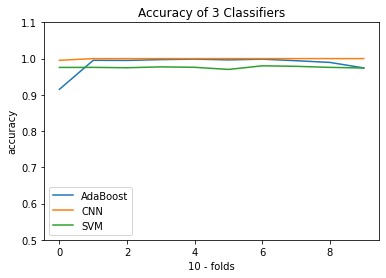

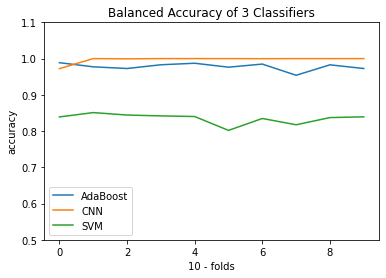

In [55]:
import matplotlib.pyplot as plt
def plot_accuracy(mat_abc, mat_cnn, mat_svc, title):
    line, = plt.plot([i for i in range(len(mat_abc))],mat_abc)
    line.set_label('AdaBoost')
    line, = plt.plot([i for i in range(len(mat_cnn))],mat_cnn)
    line.set_label('CNN')
    line, = plt.plot([i for i in range(len(mat_svc))],mat_svc)
    line.set_label('SVM')
    plt.title(title)
    plt.xlabel('10 - folds')
    plt.ylabel('accuracy')
    plt.ylim(0.5, 1.1)
    plt.legend()
    plt.show()

    
plot_accuracy(accuracies_abc, accuracies_cnn, accuracies_svc, "Accuracy of 3 Classifiers")
plot_accuracy(accuracies_balanced_abc, accuracies_balanced_cnn, accuracies_balanced_svc, "Balanced Accuracy of 3 Classifiers")



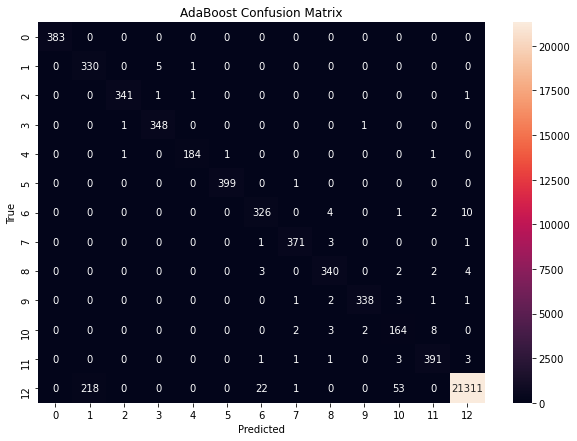

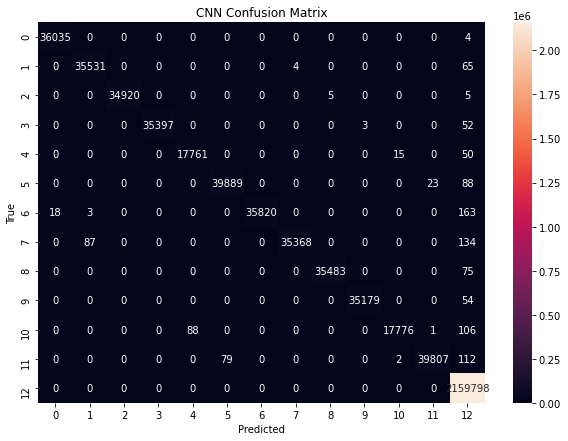

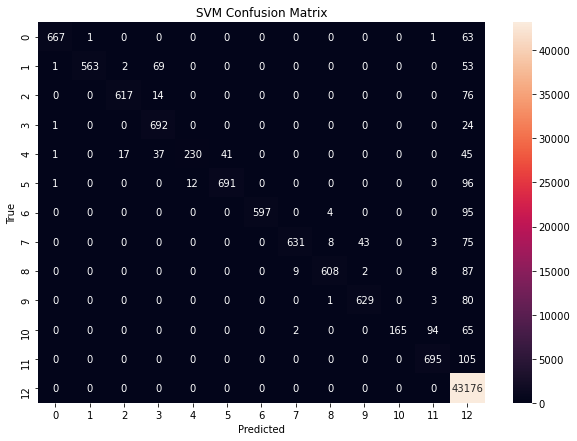

In [56]:
import seaborn as sns
def plot_confusion_mat(conf_mat, title = ""):
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(conf_mat, annot=True, fmt="d")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()
    
plot_confusion_mat(sum(confusion_matrices_abc), title = "AdaBoost Confusion Matrix" )
plot_confusion_mat(sum(confusion_matrices_cnn), title = "CNN Confusion Matrix" )
plot_confusion_mat(sum(confusion_matrices_svc), title = "SVM Confusion Matrix" )


### Bonus: GUI: see GUI_with_Classifiers.ipynb